In [5]:
import numpy as np 
import pandas as pd
from scipy import stats
import lifetimes
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/cleaned_data/online_retail_df.csv')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396340 entries, 0 to 396339
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    396340 non-null  int64  
 1   StockCode    396340 non-null  object 
 2   Description  396340 non-null  object 
 3   Quantity     396340 non-null  int64  
 4   InvoiceDate  396340 non-null  object 
 5   UnitPrice    396340 non-null  float64
 6   CustomerID   396340 non-null  float64
 7   Country      396340 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 24.2+ MB


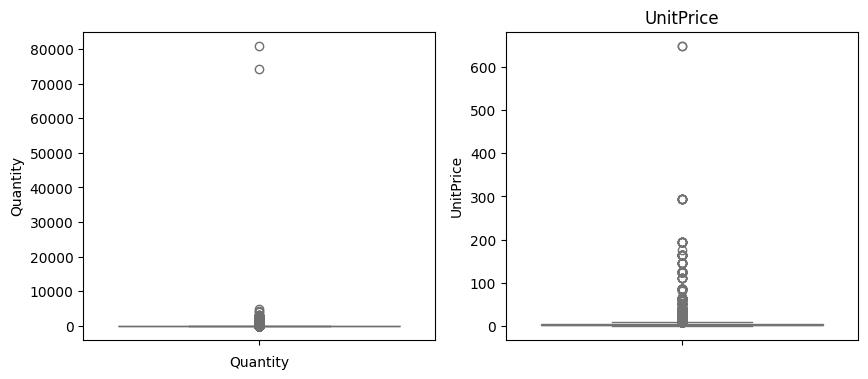

In [4]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
sns.boxplot(df['Quantity'],color = 'skyblue')
plt.xlabel('Quantity')

plt.subplot(1,2,2)
sns.boxplot(df['UnitPrice'],color = 'lightgreen')
plt.title('UnitPrice')

plt.show()

Geez, that's a lot of outlier. We need to handle them here.

In [13]:



def clean_online_retail_data(df):
    """
    Clean online retail data for BetaGeo modeling
    """
    print(f"Original data shape: {df.shape}")
    
    # 1. Remove clearly invalid records
    df_clean = df.copy()
    
    # Remove negative quantities and prices
    df_clean = df_clean[df_clean['Quantity'] > 0]
    df_clean = df_clean[df_clean['UnitPrice'] > 0]
    print(f"After removing negative values: {df_clean.shape}")
    
    # 2. Handle extreme outliers using IQR method
    def remove_outliers_iqr(data, column, multiplier=3):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        print(f"{column} bounds: {lower_bound:.2f} to {upper_bound:.2f}")
        return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    # Remove quantity outliers
    df_clean = remove_outliers_iqr(df_clean, 'Quantity', multiplier=2.5)
    print(f"After removing quantity outliers: {df_clean.shape}")
    
    # Remove price outliers
    df_clean = remove_outliers_iqr(df_clean, 'UnitPrice', multiplier=2.5)
    print(f"After removing price outliers: {df_clean.shape}")
    
    # 3. Remove bulk/wholesale orders (common in retail data)
    # These distort individual customer behavior
    quantity_95th = df_clean['Quantity'].quantile(0.95)
    df_clean = df_clean[df_clean['Quantity'] <= quantity_95th]
    print(f"After removing bulk orders (>95th percentile): {df_clean.shape}")
    
    # 4. Calculate total spend per transaction
    df_clean['TotalSpend'] = df_clean['Quantity'] * df_clean['UnitPrice']
    
    # 5. Remove customers with very few transactions (less reliable for modeling)
    customer_transaction_counts = df_clean.groupby('CustomerID').size()
    valid_customers = customer_transaction_counts[customer_transaction_counts >= 3].index
    df_clean = df_clean[df_clean['CustomerID'].isin(valid_customers)]
    print(f"After removing customers with <3 transactions: {df_clean.shape}")
    
    # 6. Remove test/employee accounts (common patterns)
    # Look for customers with suspicious patterns
    customer_stats = df_clean.groupby('CustomerID').agg({
        'Quantity': ['mean', 'std', 'count'],
        'UnitPrice': ['mean', 'std'],
        'TotalSpend': ['mean', 'sum']
    }).round(2)
    
    # Flatten column names
    customer_stats.columns = ['_'.join(col).strip() for col in customer_stats.columns]
    
    # Remove customers with extremely high average quantities (likely test accounts)
    high_avg_qty = customer_stats['Quantity_mean'].quantile(0.99)
    suspicious_customers = customer_stats[customer_stats['Quantity_mean'] > high_avg_qty].index
    df_clean = df_clean[~df_clean['CustomerID'].isin(suspicious_customers)]
    print(f"After removing suspicious accounts: {df_clean.shape}")
    
    return df_clean, customer_stats

def validate_cleaning(df_original, df_clean):
    """
    Validate the cleaning process
    """
    print("\n=== CLEANING VALIDATION ===")
    
    # Compare distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Quantity comparison
    axes[0,0].boxplot([df_original['Quantity'], df_clean['Quantity']], 
                      labels=['Original', 'Cleaned'])
    axes[0,0].set_title('Quantity Distribution')
    axes[0,0].set_yscale('log')
    
    # Price comparison
    axes[0,1].boxplot([df_original['UnitPrice'], df_clean['UnitPrice']], 
                      labels=['Original', 'Cleaned'])
    axes[0,1].set_title('Unit Price Distribution')
    axes[0,1].set_yscale('log')
    
    # Customer transaction frequency
    orig_freq = df_original.groupby('CustomerID').size()
    clean_freq = df_clean.groupby('CustomerID').size()
    
    axes[1,0].hist(orig_freq, bins=50, alpha=0.5, label='Original')
    axes[1,0].hist(clean_freq, bins=50, alpha=0.5, label='Cleaned')
    axes[1,0].set_title('Customer Transaction Frequency')
    axes[1,0].legend()
    
    # Total spend per transaction
    df_original['TotalSpend'] = df_original['Quantity'] * df_original['UnitPrice']
    
    axes[1,1].hist(np.log10(df_original['TotalSpend'] + 1), bins=50, alpha=0.5, label='Original')
    axes[1,1].hist(np.log10(df_clean['TotalSpend'] + 1), bins=50, alpha=0.5, label='Cleaned')
    axes[1,1].set_title('Log10(Total Spend per Transaction)')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Data reduction: {len(df_original)} → {len(df_clean)} rows ({len(df_clean)/len(df_original)*100:.1f}% retained)")
    print(f"Customer reduction: {df_original['CustomerID'].nunique()} → {df_clean['CustomerID'].nunique()} customers")
    
    return True

In [14]:
# Clean the data
df_clean, customer_stats = clean_online_retail_data(df)


Original data shape: (396340, 9)
After removing negative values: (396340, 9)
Quantity bounds: -23.00 to 37.00
After removing quantity outliers: (376743, 9)
UnitPrice bounds: -5.00 to 10.00
After removing price outliers: (367267, 9)
After removing bulk orders (>95th percentile): (356238, 9)
After removing customers with <3 transactions: (356061, 9)
After removing suspicious accounts: (355588, 9)



=== CLEANING VALIDATION ===


C:\Users\HP\AppData\Local\Temp\ipykernel_17276\1496648728.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot([df_original['Quantity'], df_clean['Quantity']],
C:\Users\HP\AppData\Local\Temp\ipykernel_17276\1496648728.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([df_original['UnitPrice'], df_clean['UnitPrice']],


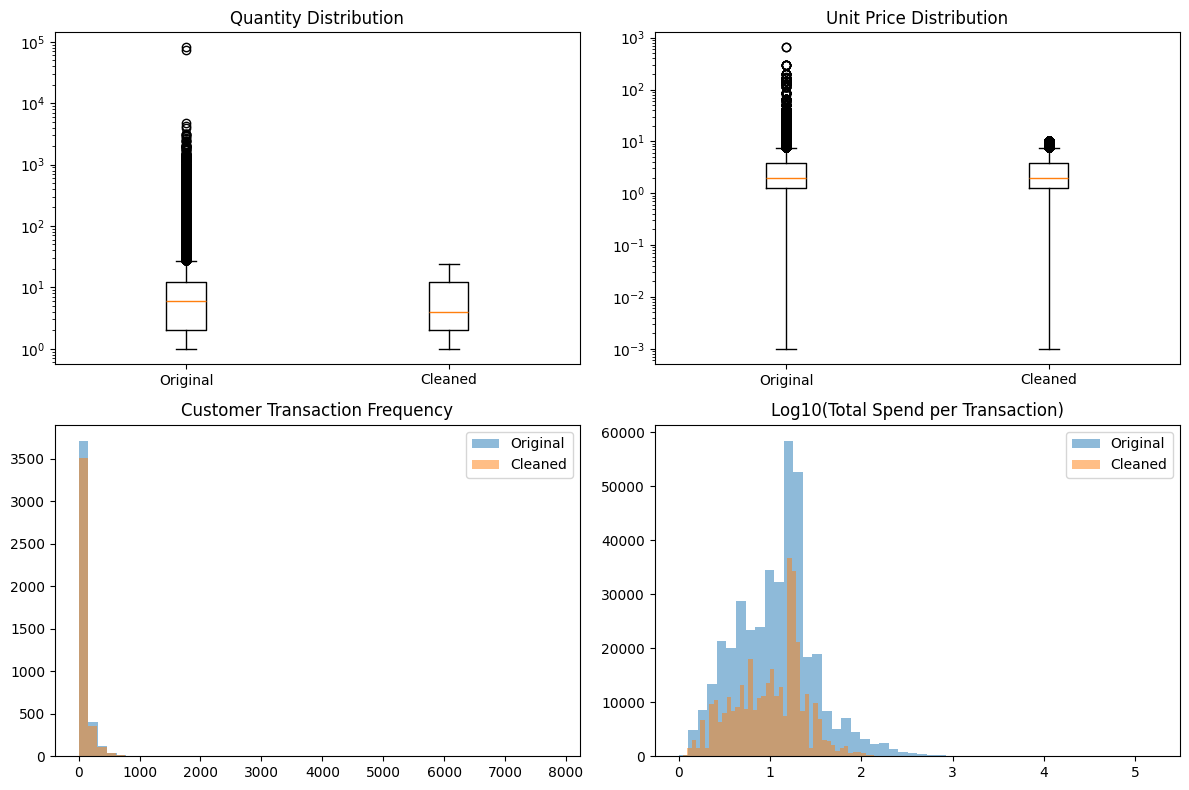

Data reduction: 396340 → 355588 rows (89.7% retained)
Customer reduction: 4334 → 4046 customers


True

In [15]:
# Validate cleaning
validate_cleaning(df, df_clean)

In [16]:
from datetime import datetime, timedelta

def create_retail_rfm(df_clean, observation_period_end=None):
    """
    Create RFM data specifically for online retail BetaGeo modeling
    """
    # Ensure proper date formatting
    df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
    
    # Set observation period end (use last date in data if not specified)
    if observation_period_end is None:
        observation_period_end = df_clean['InvoiceDate'].max()
    else:
        observation_period_end = pd.to_datetime(observation_period_end)
    
    print(f"Analysis period: {df_clean['InvoiceDate'].min()} to {observation_period_end}")
    
    # Group by customer and date to get daily purchase behavior
    # This is important for retail where customers might make multiple purchases per day
    daily_purchases = df_clean.groupby(['CustomerID', df_clean['InvoiceDate'].dt.date]).agg({
        'TotalSpend': 'sum',
        'InvoiceNo': 'nunique'  # Number of unique invoices per day
    }).reset_index()
    
    # Calculate RFM metrics
    def calculate_customer_rfm(customer_data):
        # Sort by date
        customer_data = customer_data.sort_values('InvoiceDate')
        
        # Frequency: Number of purchase days - 1 (as per BetaGeo convention)
        frequency = len(customer_data) - 1
        
        # Recency: Days between first and last purchase
        if len(customer_data) > 1:
            recency = (customer_data['InvoiceDate'].iloc[-1] - customer_data['InvoiceDate'].iloc[0]).days
        else:
            recency = 0
        
        # T: Days between first purchase and end of observation period
        T = (observation_period_end.date() - customer_data['InvoiceDate'].iloc[0]).days
        
        # Additional metrics for validation
        total_spend = customer_data['TotalSpend'].sum()
        avg_spend = customer_data['TotalSpend'].mean()
        first_purchase = customer_data['InvoiceDate'].iloc[0]
        last_purchase = customer_data['InvoiceDate'].iloc[-1]
        
        return pd.Series({
            'frequency': frequency,
            'recency': recency,
            'T': T,
            'total_spend': total_spend,
            'avg_spend_per_day': avg_spend,
            'first_purchase_date': first_purchase,
            'last_purchase_date': last_purchase,
            'purchase_days': len(customer_data)
        })
    
    # Apply RFM calculation to each customer
    rfm_data = daily_purchases.groupby('CustomerID').apply(calculate_customer_rfm).reset_index()
    
    # Data quality checks for RFM
    print("\n=== RFM DATA QUALITY CHECKS ===")
    print(f"Total customers: {len(rfm_data)}")
    print(f"Customers with frequency > 0: {(rfm_data['frequency'] > 0).sum()}")
    print(f"Customers with T > recency: {(rfm_data['T'] >= rfm_data['recency']).sum()}")
    
    # Remove customers with invalid data
    valid_customers = (
        (rfm_data['T'] >= rfm_data['recency']) & 
        (rfm_data['T'] > 0) &
        (rfm_data['recency'] >= 0)
    )
    
    rfm_clean = rfm_data[valid_customers].copy()
    print(f"Valid customers after filtering: {len(rfm_clean)}")
    
    # Summary statistics
    print("\n=== RFM SUMMARY STATISTICS ===")
    print(rfm_clean[['frequency', 'recency', 'T', 'total_spend']].describe())
    
    return rfm_clean

def validate_rfm_for_betageo(rfm_data):
    """
    Validate RFM data before fitting BetaGeo model
    """
    issues = []
    
    # Check 1: T >= recency for all customers
    if not (rfm_data['T'] >= rfm_data['recency']).all():
        issues.append("Some customers have T < recency")
    
    # Check 2: Reasonable frequency distribution
    if rfm_data['frequency'].max() > 365:
        issues.append("Some customers have unrealistic high frequency (>365 purchases)")
    
    # Check 3: Sufficient variation in behavior
    if rfm_data['frequency'].std() < 1:
        issues.append("Very low variation in customer frequency")
    
    # Check 4: Reasonable time periods
    if rfm_data['T'].max() > 365 * 3:  # More than 3 years
        issues.append("Very long observation period might affect model stability")
    
    # Check 5: Minimum sample size
    if len(rfm_data) < 1000:
        issues.append("Small sample size might cause parameter instability")
    
    if issues:
        print("⚠️  POTENTIAL ISSUES FOUND:")
        for issue in issues:
            print(f"   - {issue}")
    else:
        print("✅ RFM data looks good for BetaGeo modeling")
    
    # Visualize RFM distributions
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Frequency distribution
    axes[0,0].hist(rfm_data['frequency'], bins=50, edgecolor='black')
    axes[0,0].set_title('Frequency Distribution')
    axes[0,0].set_xlabel('Purchase Frequency')
    
    # Recency distribution
    axes[0,1].hist(rfm_data['recency'], bins=50, edgecolor='black')
    axes[0,1].set_title('Recency Distribution')
    axes[0,1].set_xlabel('Days Since Last Purchase')
    
    # T distribution
    axes[1,0].hist(rfm_data['T'], bins=50, edgecolor='black')
    axes[1,0].set_title('T Distribution')
    axes[1,0].set_xlabel('Days Since First Purchase')
    
    # Frequency vs Recency scatter
    axes[1,1].scatter(rfm_data['frequency'], rfm_data['recency'], alpha=0.5)
    axes[1,1].set_xlabel('Frequency')
    axes[1,1].set_ylabel('Recency')
    axes[1,1].set_title('Frequency vs Recency')
    
    plt.tight_layout()
    plt.show()
    
    return len(issues) == 0



In [17]:
# After cleaning your data
rfm_data = create_retail_rfm(df_clean)

Analysis period: 2010-12-01 08:26:00 to 2011-12-09 12:50:00

=== RFM DATA QUALITY CHECKS ===
Total customers: 4046
Customers with frequency > 0: 2646
Customers with T > recency: 4046
Valid customers after filtering: 4045

=== RFM SUMMARY STATISTICS ===
         frequency      recency            T   total_spend
count  4045.000000  4045.000000  4045.000000   4045.000000
mean      2.817058   133.371817   223.297651   1173.420859
std       5.766445   131.832518   117.451875   2491.992391
min       0.000000     0.000000     1.000000     13.300000
25%       0.000000     0.000000   114.000000    251.240000
50%       1.000000   103.000000   249.000000    554.060000
75%       3.000000   254.000000   326.000000   1294.130000
max     129.000000   373.000000   373.000000  96295.360000


✅ RFM data looks good for BetaGeo modeling


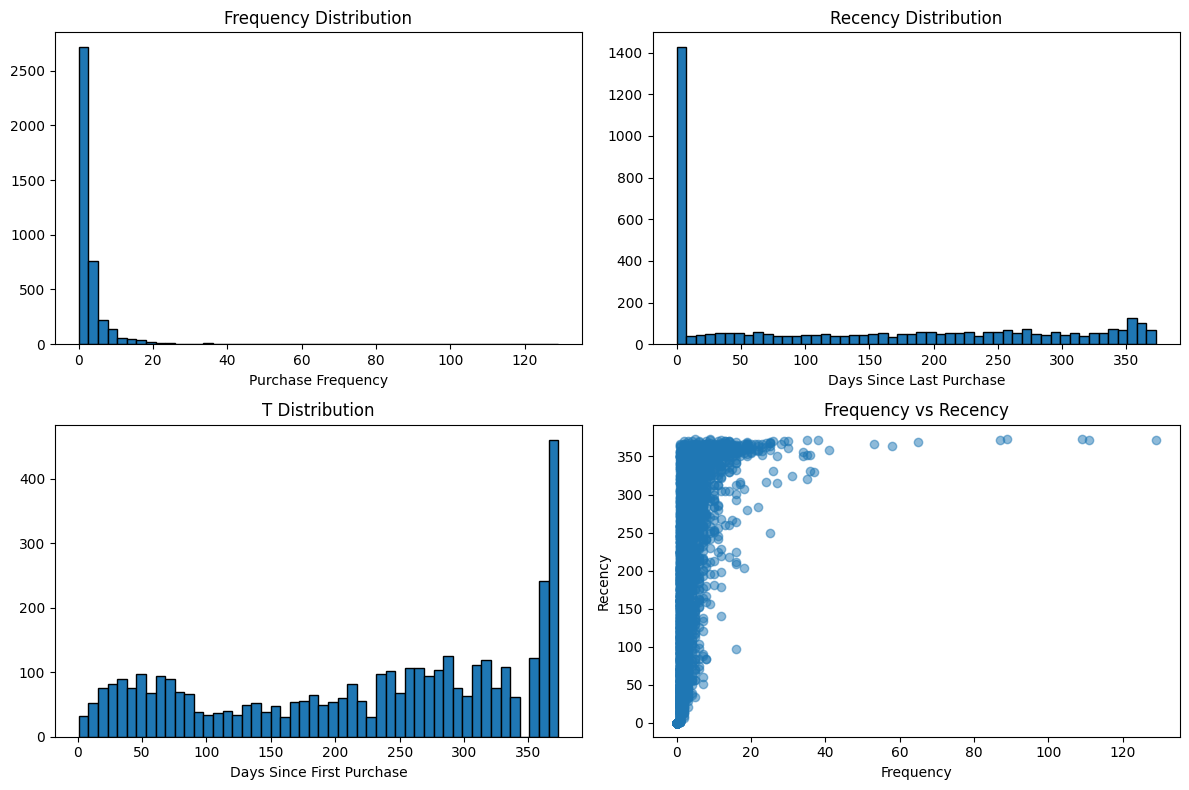

In [18]:
# Validate before modeling
is_valid = validate_rfm_for_betageo(rfm_data)

In [21]:
if is_valid:
    # Proceed with BetaGeo modeling
    from lifetimes import BetaGeoFitter
    
    bgf = BetaGeoFitter(penalizer_coef=0.1)  # Add small penalty for stability
    bgf.fit(rfm_data['frequency'], rfm_data['recency'], rfm_data['T'])
    print(bgf.summary)

               coef      se(coef)  lower 95% bound  upper 95% bound
r      6.157436e-01  1.570806e-02     5.849558e-01     6.465313e-01
alpha  5.188357e+01  1.758032e+00     4.843782e+01     5.532931e+01
a      3.688703e-16  3.870339e-11    -7.585828e-11     7.585902e-11
b      2.358362e-07  2.474183e-02    -4.849375e-02     4.849422e-02


In [24]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.utils import calibration_and_holdout_data
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore') 

def fit_retail_betageo(rfm_data, use_penalization=True, penalizer_coef=0.01):
    """
    Fit BetaGeo model optimized for retail data
    """
    print("=== FITTING BETAGEO MODEL FOR RETAIL DATA ===")
    
    # Try multiple fitting strategies
    strategies = [
        {"penalizer_coef": penalizer_coef, "name": "Penalized"},
        {"penalizer_coef": 0.0, "name": "Unpenalized"},
        {"penalizer_coef": penalizer_coef * 10, "name": "Heavily Penalized"}
    ]
    
    best_model = None
    best_ll = -np.inf
    
    for strategy in strategies:
        try:
            print(f"\nTrying {strategy['name']} approach...")
            
            bgf = BetaGeoFitter(penalizer_coef=strategy['penalizer_coef'])
            bgf.fit(rfm_data['frequency'], rfm_data['recency'], rfm_data['T'], 
                   verbose=True, tol=1e-6, max_iter=2000)
            
            # Check if model converged properly
            if not np.any(np.isnan(bgf.params_)):
                ll = bgf._negative_log_likelihood(bgf.params_,
                                                rfm_data['frequency'], 
                                                rfm_data['recency'], 
                                                rfm_data['T'])
                
                print(f"Log-likelihood: {-ll:.2f}")
                print(f"Parameters: {dict(bgf.params_)}")
                
                # Check parameter bounds (reasonable values for retail)
                params_reasonable = (
                    0.01 <= bgf.params_['r'] <= 10 and
                    0.1 <= bgf.params_['alpha'] <= 1000 and
                    0.001 <= bgf.params_['a'] <= 1 and
                    0.1 <= bgf.params_['b'] <= 100
                )
                
                if params_reasonable and -ll > best_ll:
                    best_model = bgf
                    best_ll = -ll
                    print("✅ Best model so far!")
                else:
                    print("❌ Parameters out of reasonable bounds")
            else:
                print("❌ Model failed to converge")
                
        except Exception as e:
            print(f"❌ Error fitting {strategy['name']}: {str(e)}")
    
    if best_model is None:
        print("⚠️  All fitting strategies failed. Trying simplified approach...")
        # Last resort: fix some parameters
        bgf = BetaGeoFitter()
        # Use method of moments for initial estimates
        initial_params = estimate_initial_params(rfm_data)
        bgf.fit(rfm_data['frequency'], rfm_data['recency'], rfm_data['T'],
               initial_params=initial_params)
        best_model = bgf
    
    return best_model

def estimate_initial_params(rfm_data):
    """
    Estimate reasonable initial parameters for retail data
    """
    # Based on typical retail customer behavior
    mean_freq = rfm_data['frequency'].mean()
    mean_recency = rfm_data['recency'].mean()
    mean_T = rfm_data['T'].mean()
    
    # Conservative estimates for retail
    r_init = max(0.1, min(2.0, mean_freq / 10))
    alpha_init = max(1.0, min(50.0, mean_T / mean_recency if mean_recency > 0 else 10))
    a_init = 0.1  # Conservative dropout rate
    b_init = max(1.0, min(10.0, mean_T / 100))
    
    return [r_init, alpha_init, a_init, b_init]

def validate_retail_betageo(bgf, rfm_data, holdout_days=30):
    """
    Comprehensive validation for retail BetaGeo model
    """
    print("\n=== MODEL VALIDATION ===")
    
    # 1. Parameter Analysis
    print("1. Parameter Analysis:")
    params = bgf.params_
    print(f"   r (purchase rate heterogeneity): {params['r']:.4f}")
    print(f"   alpha (purchase rate): {params['alpha']:.4f}")
    print(f"   a (dropout heterogeneity): {params['a']:.4f}")
    print(f"   b (dropout rate): {params['b']:.4f}")
    
    # Parameter interpretation for retail
    avg_purchase_rate = params['r'] / params['alpha']
    avg_dropout_prob = params['a'] / (params['a'] + params['b'])
    
    print(f"   → Average purchase rate: {avg_purchase_rate:.4f} per period")
    print(f"   → Average dropout probability: {avg_dropout_prob:.4f}")
    
    # 2. Business Logic Checks
    print("\n2. Business Logic Validation:")
    
    # Check: High frequency customers should be more likely alive
    high_freq = rfm_data.nlargest(100, 'frequency')
    low_freq = rfm_data.nsmallest(100, 'frequency')
    
    high_freq_alive = bgf.conditional_probability_alive(
        high_freq['frequency'], high_freq['recency'], high_freq['T']
    ).mean()
    
    low_freq_alive = bgf.conditional_probability_alive(
        low_freq['frequency'], low_freq['recency'], low_freq['T']
    ).mean()
    
    print(f"   High frequency customers alive prob: {high_freq_alive:.3f}")
    print(f"   Low frequency customers alive prob: {low_freq_alive:.3f}")
    print(f"   ✅ Logic check: {high_freq_alive > low_freq_alive}")
    
    # Check: Recent customers should be more likely alive
    recent = rfm_data.nlargest(100, 'recency')
    old = rfm_data.nsmallest(100, 'recency')
    
    recent_alive = bgf.conditional_probability_alive(
        recent['frequency'], recent['recency'], recent['T']
    ).mean()
    
    old_alive = bgf.conditional_probability_alive(
        old['frequency'], old['recency'], old['T']
    ).mean()
    
    print(f"   Recent customers alive prob: {recent_alive:.3f}")
    print(f"   Old customers alive prob: {old_alive:.3f}")
    print(f"   ✅ Recency check: {recent_alive > old_alive}")
    
    # 3. Holdout Validation (if enough data)
    if rfm_data['T'].min() > holdout_days:
        print(f"\n3. Holdout Validation ({holdout_days} days):")
        try:
            # Create calibration and holdout data
            summary_cal_holdout = calibration_and_holdout_data(
                rfm_data, 'CustomerID', 'T', 
                calibration_period_end=holdout_days,
                observation_period_end=rfm_data['T'].max()
            )
            
            # Fit on calibration data
            bgf_cal = BetaGeoFitter(penalizer_coef=bgf.penalizer_coef)
            bgf_cal.fit(summary_cal_holdout['frequency_cal'], 
                       summary_cal_holdout['recency_cal'], 
                       summary_cal_holdout['T_cal'])
            
            # Predict on holdout
            predictions = bgf_cal.predict(
                holdout_days,
                summary_cal_holdout['frequency_cal'],
                summary_cal_holdout['recency_cal'],
                summary_cal_holdout['T_cal']
            )
            
            # Calculate MAE
            mae = np.mean(np.abs(predictions - summary_cal_holdout['frequency_holdout']))
            mape = np.mean(np.abs((predictions - summary_cal_holdout['frequency_holdout']) / 
                                (summary_cal_holdout['frequency_holdout'] + 0.1))) * 100
            
            print(f"   Mean Absolute Error: {mae:.3f}")
            print(f"   Mean Absolute Percentage Error: {mape:.1f}%")
            
        except Exception as e:
            print(f"   ❌ Holdout validation failed: {str(e)}")
    
    # 4. Visualization
    print("\n4. Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot probability alive matrix
    plot_probability_alive_matrix(bgf, ax=axes[0,0])
    axes[0,0].set_title('Probability Customer is Alive')
    
    # Plot frequency/recency matrix
    plot_frequency_recency_matrix(bgf, ax=axes[0,1])
    axes[0,1].set_title('Expected Purchases')
    
    # Distribution of predicted vs actual
    predicted_purchases = bgf.conditional_expected_number_of_purchases_up_to_time(
        30, rfm_data['frequency'], rfm_data['recency'], rfm_data['T']
    )
    
    axes[1,0].hist(predicted_purchases, bins=50, alpha=0.7, label='Predicted (30 days)')
    axes[1,0].set_xlabel('Expected Purchases')
    axes[1,0].set_ylabel('Number of Customers')
    axes[1,0].set_title('Distribution of Predicted Purchases')
    axes[1,0].legend()
    
    # Alive probability distribution
    alive_probs = bgf.conditional_probability_alive(
        rfm_data['frequency'], rfm_data['recency'], rfm_data['T']
    )
    
    axes[1,1].hist(alive_probs, bins=50, alpha=0.7)
    axes[1,1].set_xlabel('Probability Alive')
    axes[1,1].set_ylabel('Number of Customers')
    axes[1,1].set_title('Distribution of Alive Probabilities')
    
    plt.tight_layout()
    plt.show()
    
    return True

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class MLCLVPipeline:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.best_model = None
        self.feature_names = None
        
    def create_features(self, df, observation_period_days=365, prediction_period_days=365):
        """
        Create comprehensive features for CLV prediction
        
        Expected df columns: customer_id, order_date, order_value, product_category, etc.
        """
        
        # Convert dates
        df['order_date'] = pd.to_datetime(df['order_date'])
        
        # Define observation and prediction periods
        max_date = df['order_date'].max()
        observation_end = max_date - timedelta(days=prediction_period_days)
        observation_start = observation_end - timedelta(days=observation_period_days)
        
        # Filter data for observation period
        obs_data = df[
            (df['order_date'] >= observation_start) & 
            (df['order_date'] <= observation_end)
        ].copy()
        
        # Calculate target (future CLV)
        future_data = df[
            (df['order_date'] > observation_end) & 
            (df['order_date'] <= max_date)
        ]
        
        target = future_data.groupby('customer_id')['order_value'].sum().reset_index()
        target.columns = ['customer_id', 'future_clv']
        
        # Feature Engineering
        features = self._calculate_features(obs_data)
        
        # Merge features with target
        final_df = features.merge(target, on='customer_id', how='left')
        final_df['future_clv'] = final_df['future_clv'].fillna(0)
        
        return final_df
    
    def _calculate_features(self, df):
        """Calculate comprehensive customer features"""
        
        customer_features = []
        
        for customer_id, group in df.groupby('customer_id'):
            
            # Basic transaction features
            total_orders = len(group)
            total_revenue = group['order_value'].sum()
            avg_order_value = group['order_value'].mean()
            
            # Temporal features
            first_order = group['order_date'].min()
            last_order = group['order_date'].max()
            days_active = (last_order - first_order).days + 1
            
            # Frequency features
            purchase_frequency = total_orders / max(days_active, 1) * 30  # purchases per month
            
            # Recency features
            days_since_last_order = (df['order_date'].max() - last_order).days
            
            # Monetary features
            min_order_value = group['order_value'].min()
            max_order_value = group['order_value'].max()
            std_order_value = group['order_value'].std() if len(group) > 1 else 0
            
            # Trend features
            if len(group) >= 3:
                # Calculate trend in order values
                group_sorted = group.sort_values('order_date')
                recent_orders = group_sorted.tail(3)['order_value'].mean()
                early_orders = group_sorted.head(3)['order_value'].mean()
                order_value_trend = (recent_orders - early_orders) / early_orders if early_orders > 0 else 0
            else:
                order_value_trend = 0
            
            # Seasonal features
            group['month'] = group['order_date'].dt.month
            group['day_of_week'] = group['order_date'].dt.dayofweek
            most_active_month = group['month'].mode().iloc[0] if len(group['month'].mode()) > 0 else 1
            most_active_dow = group['day_of_week'].mode().iloc[0] if len(group['day_of_week'].mode()) > 0 else 0
            
            # Product diversity features
            if 'product_category' in group.columns:
                unique_categories = group['product_category'].nunique()
                most_frequent_category = group['product_category'].mode().iloc[0] if len(group['product_category'].mode()) > 0 else 'unknown'
            else:
                unique_categories = 1
                most_frequent_category = 'unknown'
            
            # Time-based features
            purchase_intervals = []
            if len(group) > 1:
                dates_sorted = sorted(group['order_date'])
                for i in range(1, len(dates_sorted)):
                    interval = (dates_sorted[i] - dates_sorted[i-1]).days
                    purchase_intervals.append(interval)
                
                avg_days_between_purchases = np.mean(purchase_intervals) if purchase_intervals else 0
                std_days_between_purchases = np.std(purchase_intervals) if len(purchase_intervals) > 1 else 0
            else:
                avg_days_between_purchases = 0
                std_days_between_purchases = 0
            
            customer_features.append({
                'customer_id': customer_id,
                'total_orders': total_orders,
                'total_revenue': total_revenue,
                'avg_order_value': avg_order_value,
                'days_active': days_active,
                'purchase_frequency': purchase_frequency,
                'days_since_last_order': days_since_last_order,
                'min_order_value': min_order_value,
                'max_order_value': max_order_value,
                'std_order_value': std_order_value,
                'order_value_trend': order_value_trend,
                'most_active_month': most_active_month,
                'most_active_dow': most_active_dow,
                'unique_categories': unique_categories,
                'most_frequent_category': most_frequent_category,
                'avg_days_between_purchases': avg_days_between_purchases,
                'std_days_between_purchases': std_days_between_purchases,
                'recency_score': 1 / (1 + days_since_last_order / 30),  # Exponential decay
                'frequency_score': np.log1p(total_orders),
                'monetary_score': np.log1p(total_revenue)
            })
        
        return pd.DataFrame(customer_features)
    
    def prepare_data(self, df):
        """Prepare features for ML models"""
        
        # Separate features and target
        feature_cols = [col for col in df.columns if col not in ['customer_id', 'future_clv']]
        X = df[feature_cols].copy()
        y = df['future_clv'].copy()
        
        # Handle categorical variables
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                X[col] = self.label_encoders[col].fit_transform(X[col].astype(str))
            else:
                X[col] = self.label_encoders[col].transform(X[col].astype(str))
        
        # Handle missing values
        X = X.fillna(0)
        
        # Store feature names
        self.feature_names = X.columns.tolist()
        
        return X, y
    
    def create_splits(self, X, y, test_size=0.2, val_size=0.2):
        """Create proper train/validation/test splits"""
        
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=None
        )
        
        # Second split: separate train and validation
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=42
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)
        
        return (X_train_scaled, X_val_scaled, X_test_scaled, 
                y_train, y_val, y_test)
    
    def optuna_objective(self, trial, X_train, X_val, y_train, y_val, model_type='xgboost'):
        """Optuna objective function for hyperparameter tuning"""
        
        if model_type == 'xgboost':
            params = {
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': 42
            }
            
            model = xgb.XGBRegressor(**params)
            
        elif model_type == 'lightgbm':
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': 42,
                'verbosity': -1
            }
            
            model = lgb.LGBMRegressor(**params)
            
        elif model_type == 'random_forest':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'random_state': 42
            }
            
            model = RandomForestRegressor(**params)
        
        # Train and evaluate
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        return rmse
    
    def hyperparameter_tuning(self, X_train, X_val, y_train, y_val, 
                            model_types=['xgboost', 'lightgbm', 'random_forest'], 
                            n_trials=100):
        """Perform hyperparameter tuning using Optuna"""
        
        best_models = {}
        
        for model_type in model_types:
            print(f"Tuning {model_type}...")
            
            study = optuna.create_study(direction='minimize')
            study.optimize(
                lambda trial: self.optuna_objective(trial, X_train, X_val, y_train, y_val, model_type),
                n_trials=n_trials,
                show_progress_bar=True
            )
            
            # Train best model
            best_params = study.best_params
            
            if model_type == 'xgboost':
                best_params.update({
                    'objective': 'reg:squarederror',
                    'eval_metric': 'rmse',
                    'random_state': 42
                })
                best_model = xgb.XGBRegressor(**best_params)
                
            elif model_type == 'lightgbm':
                best_params.update({
                    'objective': 'regression',
                    'metric': 'rmse',
                    'random_state': 42,
                    'verbosity': -1
                })
                best_model = lgb.LGBMRegressor(**best_params)
                
            elif model_type == 'random_forest':
                best_params.update({'random_state': 42})
                best_model = RandomForestRegressor(**best_params)
            
            best_model.fit(X_train, y_train)
            best_models[model_type] = {
                'model': best_model,
                'params': best_params,
                'score': study.best_value
            }
            
            print(f"Best {model_type} RMSE: {study.best_value:.4f}")
        
        # Select overall best model
        best_model_name = min(best_models.keys(), key=lambda k: best_models[k]['score'])
        self.best_model = best_models[best_model_name]['model']
        
        print(f"\nBest overall model: {best_model_name}")
        return best_models
    
    def evaluate_model(self, model, X_test, y_test):
        """Evaluate model performance"""
        
        y_pred = model.predict(X_test)
        
        metrics = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R²': r2_score(y_test, y_pred),
            'MAPE': np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        }
        
        return metrics, y_pred
    
    def get_feature_importance(self, model):
        """Get feature importance"""
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_)
        else:
            return None
        
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return feature_importance

# Advanced hyperparameter tuning alternatives
class AdvancedHyperparameterTuning:
    
    @staticmethod
    def bayesian_optimization_sklearn(X_train, X_val, y_train, y_val):
        """Using scikit-optimize for Bayesian optimization"""
        from skopt import gp_minimize
        from skopt.space import Real, Integer
        from skopt.utils import use_named_args
        
        # Define search space
        space = [
            Integer(100, 1000, name='n_estimators'),
            Integer(3, 10, name='max_depth'),
            Real(0.01, 0.3, name='learning_rate'),
            Real(0.6, 1.0, name='subsample'),
            Real(0.6, 1.0, name='colsample_bytree'),
        ]
        
        @use_named_args(space)
        def objective(**params):
            model = xgb.XGBRegressor(**params, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, y_pred))
        
        result = gp_minimize(objective, space, n_calls=50, random_state=42)
        return result
    
    @staticmethod
    def hyperband_tuning():
        """Using Hyperband algorithm (implemented in Optuna)"""
        
        def objective(trial):
            # Hyperband automatically handles resource allocation
            model = xgb.XGBRegressor(
                n_estimators=trial.suggest_int('n_estimators', 50, 500),
                max_depth=trial.suggest_int('max_depth', 3, 10),
                learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
                random_state=42
            )
            return 0  # Placeholder
        
        # Use Hyperband pruner
        study = optuna.create_study(
            direction='minimize',
            pruner=optuna.pruners.HyperbandPruner()
        )
        
        return study

# Example usage and demo
def demo_ml_clv():
    """Demonstrate the ML CLV pipeline"""
    
    # Generate sample data
    np.random.seed(42)
    
    # Create sample transaction data
    customers = [f'customer_{i}' for i in range(1000)]
    data = []
    
    for customer in customers:
        # Random customer behavior
        n_orders = np.random.poisson(5) + 1
        start_date = datetime(2023, 1, 1) + timedelta(days=np.random.randint(0, 365))
        
        for i in range(n_orders):
            order_date = start_date + timedelta(days=np.random.exponential(30) * i)
            if order_date <= datetime(2024, 12, 31):
                order_value = np.random.lognormal(4, 0.5)  # Log-normal distribution
                category = np.random.choice(['Electronics', 'Clothing', 'Books', 'Home'])
                
                data.append({
                    'customer_id': customer,
                    'order_date': order_date,
                    'order_value': order_value,
                    'product_category': category
                })
    
    df = pd.DataFrame(data)
    
    # Initialize pipeline
    pipeline = MLCLVPipeline()
    
    print("Creating features...")
    feature_df = pipeline.create_features(df)
    
    print("Preparing data...")
    X, y = pipeline.prepare_data(feature_df)
    
    print("Creating train/validation/test splits...")
    X_train, X_val, X_test, y_train, y_val, y_test = pipeline.create_splits(X, y)
    
    print("Starting hyperparameter tuning...")
    best_models = pipeline.hyperparameter_tuning(
        X_train, X_val, y_train, y_val, 
        model_types=['xgboost', 'lightgbm'], 
        n_trials=20  # Reduced for demo
    )
    
    print("\nEvaluating best model on test set...")
    test_metrics, y_pred = pipeline.evaluate_model(pipeline.best_model, X_test, y_test)
    
    print("Test Set Performance:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nTop 10 Feature Importances:")
    feature_importance = pipeline.get_feature_importance(pipeline.best_model)
    print(feature_importance.head(10))
    
    return pipeline, best_models, test_metrics



In [28]:
pipeline, models, metrics = demo_ml_clv()

Creating features...


[I 2025-07-01 17:35:35,994] A new study created in memory with name: no-name-5ae9c23e-ffae-43ad-9e3e-aeec31ca8a9e


Preparing data...
Creating train/validation/test splits...
Starting hyperparameter tuning...
Tuning xgboost...


Best trial: 0. Best value: 75.5097:  10%|█         | 2/20 [00:03<00:25,  1.42s/it]

[I 2025-07-01 17:35:39,415] Trial 0 finished with value: 75.50967681961072 and parameters: {'n_estimators': 592, 'max_depth': 8, 'learning_rate': 0.01947005795341175, 'subsample': 0.9413120678052599, 'colsample_bytree': 0.6890311742518873, 'reg_alpha': 0.6339428679668269, 'reg_lambda': 0.8992190116498477}. Best is trial 0 with value: 75.50967681961072.
[I 2025-07-01 17:35:39,619] Trial 1 finished with value: 79.65773821892654 and parameters: {'n_estimators': 131, 'max_depth': 5, 'learning_rate': 0.24534196846672213, 'subsample': 0.7249388551774366, 'colsample_bytree': 0.7940859994830654, 'reg_alpha': 2.9448973512786236, 'reg_lambda': 0.9881467324687299}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  15%|█▌        | 3/20 [00:03<00:17,  1.03s/it]

[I 2025-07-01 17:35:40,197] Trial 2 finished with value: 80.99031836875962 and parameters: {'n_estimators': 984, 'max_depth': 3, 'learning_rate': 0.04057947402976368, 'subsample': 0.6481525037312532, 'colsample_bytree': 0.7553843068128515, 'reg_alpha': 7.841750956893485, 'reg_lambda': 6.318350384509918}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  20%|██        | 4/20 [00:04<00:15,  1.01it/s]

[I 2025-07-01 17:35:41,113] Trial 3 finished with value: 81.96685423952717 and parameters: {'n_estimators': 657, 'max_depth': 6, 'learning_rate': 0.2725801211887605, 'subsample': 0.6159141924990632, 'colsample_bytree': 0.8558148614783967, 'reg_alpha': 1.9912009762346117, 'reg_lambda': 4.905402563802319}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  25%|██▌       | 5/20 [00:06<00:17,  1.17s/it]

[I 2025-07-01 17:35:42,613] Trial 4 finished with value: 80.46018323422751 and parameters: {'n_estimators': 382, 'max_depth': 6, 'learning_rate': 0.04956892443306081, 'subsample': 0.7168427394786434, 'colsample_bytree': 0.9510271347720716, 'reg_alpha': 3.474168104357976, 'reg_lambda': 2.54202141731667}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  30%|███       | 6/20 [00:07<00:14,  1.05s/it]

[I 2025-07-01 17:35:43,414] Trial 5 finished with value: 81.82507203360535 and parameters: {'n_estimators': 958, 'max_depth': 4, 'learning_rate': 0.18609752140254202, 'subsample': 0.9162941823906681, 'colsample_bytree': 0.829944614472211, 'reg_alpha': 4.851685582084181, 'reg_lambda': 5.543497780653928}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

[I 2025-07-01 17:35:44,937] Trial 6 finished with value: 79.64565004030497 and parameters: {'n_estimators': 512, 'max_depth': 8, 'learning_rate': 0.14398366322188508, 'subsample': 0.9196842970340353, 'colsample_bytree': 0.6000976967941504, 'reg_alpha': 7.038803256684573, 'reg_lambda': 6.677844186684643}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  40%|████      | 8/20 [00:11<00:22,  1.84s/it]

[I 2025-07-01 17:35:48,141] Trial 7 finished with value: 77.47501420116758 and parameters: {'n_estimators': 710, 'max_depth': 8, 'learning_rate': 0.018894192575569346, 'subsample': 0.820842854289466, 'colsample_bytree': 0.7908216992146362, 'reg_alpha': 4.136524702080425, 'reg_lambda': 3.7312790715229314}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  45%|████▌     | 9/20 [00:12<00:17,  1.56s/it]

[I 2025-07-01 17:35:49,085] Trial 8 finished with value: 87.75195033868206 and parameters: {'n_estimators': 905, 'max_depth': 4, 'learning_rate': 0.17662488121802025, 'subsample': 0.8355588132596277, 'colsample_bytree': 0.8543467424146091, 'reg_alpha': 4.29300176265847, 'reg_lambda': 9.206348298200526}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  50%|█████     | 10/20 [00:13<00:12,  1.29s/it]

[I 2025-07-01 17:35:49,781] Trial 9 finished with value: 80.25210012429105 and parameters: {'n_estimators': 340, 'max_depth': 8, 'learning_rate': 0.15574822612300365, 'subsample': 0.9489339724069362, 'colsample_bytree': 0.6615336180664438, 'reg_alpha': 6.182904026191446, 'reg_lambda': 0.03255867532486634}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  55%|█████▌    | 11/20 [00:15<00:13,  1.52s/it]

[I 2025-07-01 17:35:51,809] Trial 10 finished with value: 77.16732177247462 and parameters: {'n_estimators': 687, 'max_depth': 10, 'learning_rate': 0.08998162013027027, 'subsample': 0.9982222469085074, 'colsample_bytree': 0.7071395411540057, 'reg_alpha': 9.995010523264343, 'reg_lambda': 2.3200813663999913}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  60%|██████    | 12/20 [00:17<00:13,  1.70s/it]

[I 2025-07-01 17:35:53,938] Trial 11 finished with value: 77.95332739694723 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.09642983000559785, 'subsample': 0.9775708578857457, 'colsample_bytree': 0.701144896410682, 'reg_alpha': 9.875556923214155, 'reg_lambda': 1.9048541500260154}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  65%|██████▌   | 13/20 [00:19<00:13,  1.86s/it]

[I 2025-07-01 17:35:56,158] Trial 12 finished with value: 76.78315400072348 and parameters: {'n_estimators': 517, 'max_depth': 10, 'learning_rate': 0.09075966309503565, 'subsample': 0.9962018914811507, 'colsample_bytree': 0.7020353615648627, 'reg_alpha': 0.6437907712058418, 'reg_lambda': 3.098450966004073}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  70%|███████   | 14/20 [00:22<00:12,  2.06s/it]

[I 2025-07-01 17:35:58,684] Trial 13 finished with value: 76.29319734105655 and parameters: {'n_estimators': 475, 'max_depth': 9, 'learning_rate': 0.08726225303212344, 'subsample': 0.8779608446980981, 'colsample_bytree': 0.6192775512416797, 'reg_alpha': 0.059334450276252504, 'reg_lambda': 3.7709618194080874}. Best is trial 0 with value: 75.50967681961072.


Best trial: 0. Best value: 75.5097:  75%|███████▌  | 15/20 [00:24<00:10,  2.17s/it]

[I 2025-07-01 17:36:01,105] Trial 14 finished with value: 76.80068279581242 and parameters: {'n_estimators': 329, 'max_depth': 9, 'learning_rate': 0.05932013902116339, 'subsample': 0.8647014064298414, 'colsample_bytree': 0.6202563540892047, 'reg_alpha': 0.02587338929151628, 'reg_lambda': 4.203059718477528}. Best is trial 0 with value: 75.50967681961072.


Best trial: 15. Best value: 75.4732:  80%|████████  | 16/20 [00:26<00:07,  1.95s/it]

[I 2025-07-01 17:36:02,554] Trial 15 finished with value: 75.47315865235797 and parameters: {'n_estimators': 441, 'max_depth': 7, 'learning_rate': 0.013507375181297743, 'subsample': 0.8639041279288194, 'colsample_bytree': 0.658553640251239, 'reg_alpha': 1.560635694752937, 'reg_lambda': 7.643146462888401}. Best is trial 15 with value: 75.47315865235797.


Best trial: 16. Best value: 74.6092:  85%|████████▌ | 17/20 [00:27<00:05,  1.75s/it]

[I 2025-07-01 17:36:03,834] Trial 16 finished with value: 74.60919888113885 and parameters: {'n_estimators': 209, 'max_depth': 7, 'learning_rate': 0.0175527198488737, 'subsample': 0.7910723244506445, 'colsample_bytree': 0.7385303240617271, 'reg_alpha': 2.0171681428269572, 'reg_lambda': 8.529571919730499}. Best is trial 16 with value: 74.60919888113885.


Best trial: 16. Best value: 74.6092:  90%|█████████ | 18/20 [00:28<00:02,  1.40s/it]

[I 2025-07-01 17:36:04,418] Trial 17 finished with value: 80.23506031615105 and parameters: {'n_estimators': 151, 'max_depth': 7, 'learning_rate': 0.12495648471323076, 'subsample': 0.7706230903900747, 'colsample_bytree': 0.7511980149822439, 'reg_alpha': 2.07195355148479, 'reg_lambda': 8.860883430794352}. Best is trial 16 with value: 74.60919888113885.


Best trial: 18. Best value: 74.475:  95%|█████████▌| 19/20 [00:28<00:01,  1.22s/it] 

[I 2025-07-01 17:36:05,213] Trial 18 finished with value: 74.47503365978002 and parameters: {'n_estimators': 237, 'max_depth': 7, 'learning_rate': 0.01219913043858941, 'subsample': 0.7653751789099387, 'colsample_bytree': 0.9430745821813104, 'reg_alpha': 2.0120162058672983, 'reg_lambda': 7.939914582467443}. Best is trial 18 with value: 74.47503365978002.


Best trial: 18. Best value: 74.475: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


[I 2025-07-01 17:36:06,011] Trial 19 finished with value: 83.30650320473832 and parameters: {'n_estimators': 248, 'max_depth': 5, 'learning_rate': 0.20851851571929175, 'subsample': 0.7392052357781193, 'colsample_bytree': 0.9923541168695802, 'reg_alpha': 2.9052885886884767, 'reg_lambda': 9.829266350544872}. Best is trial 18 with value: 74.47503365978002.


[I 2025-07-01 17:36:07,784] A new study created in memory with name: no-name-e76b1cf6-4d2b-4bac-8b93-c0ff48c7a735


Best xgboost RMSE: 74.4750
Tuning lightgbm...


Best trial: 0. Best value: 84.859:   5%|▌         | 1/20 [00:24<07:39, 24.16s/it]

[I 2025-07-01 17:36:31,938] Trial 0 finished with value: 84.85897492257567 and parameters: {'n_estimators': 391, 'max_depth': 7, 'learning_rate': 0.24337104496692852, 'subsample': 0.6970397710841447, 'colsample_bytree': 0.8296757505062499, 'reg_alpha': 3.9828037199963906, 'reg_lambda': 7.374971885505303}. Best is trial 0 with value: 84.85897492257567.


Best trial: 2. Best value: 69.5439:  20%|██        | 4/20 [00:24<01:01,  3.84s/it]

[I 2025-07-01 17:36:32,285] Trial 1 finished with value: 81.53974322568614 and parameters: {'n_estimators': 870, 'max_depth': 7, 'learning_rate': 0.025760607793517395, 'subsample': 0.7215536727187634, 'colsample_bytree': 0.959094978641337, 'reg_alpha': 2.436609008597462, 'reg_lambda': 3.8021955235456484}. Best is trial 1 with value: 81.53974322568614.
[I 2025-07-01 17:36:32,360] Trial 2 finished with value: 69.54386306831394 and parameters: {'n_estimators': 234, 'max_depth': 4, 'learning_rate': 0.01891551461902212, 'subsample': 0.7614709031680702, 'colsample_bytree': 0.7470142820490537, 'reg_alpha': 6.38114685926544, 'reg_lambda': 8.8696085254151}. Best is trial 2 with value: 69.54386306831394.
[I 2025-07-01 17:36:32,455] Trial 3 finished with value: 88.16847250397221 and parameters: {'n_estimators': 335, 'max_depth': 5, 'learning_rate': 0.24302590172106084, 'subsample': 0.7899761882959616, 'colsample_bytree': 0.7893662845643232, 'reg_alpha': 0.3224089189922985, 'reg_lambda': 5.6249155

Best trial: 2. Best value: 69.5439:  25%|██▌       | 5/20 [00:24<00:40,  2.71s/it]

[I 2025-07-01 17:36:32,657] Trial 4 finished with value: 87.21221029632696 and parameters: {'n_estimators': 473, 'max_depth': 6, 'learning_rate': 0.16444990508661456, 'subsample': 0.6988465448421083, 'colsample_bytree': 0.9833346135098242, 'reg_alpha': 5.1627997592131045, 'reg_lambda': 0.991340651883833}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  30%|███       | 6/20 [00:25<00:28,  2.05s/it]

[I 2025-07-01 17:36:33,192] Trial 5 finished with value: 83.85260610527658 and parameters: {'n_estimators': 968, 'max_depth': 10, 'learning_rate': 0.12591935098180101, 'subsample': 0.834204772613896, 'colsample_bytree': 0.9404373624631354, 'reg_alpha': 9.80895935033205, 'reg_lambda': 8.081570046111189}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  35%|███▌      | 7/20 [00:25<00:19,  1.52s/it]

[I 2025-07-01 17:36:33,510] Trial 6 finished with value: 82.11866000141607 and parameters: {'n_estimators': 502, 'max_depth': 7, 'learning_rate': 0.05693600634482566, 'subsample': 0.8915208863059967, 'colsample_bytree': 0.7703577261894217, 'reg_alpha': 9.679215181757195, 'reg_lambda': 9.112027678699047}. Best is trial 2 with value: 69.54386306831394.
[I 2025-07-01 17:36:33,577] Trial 7 finished with value: 84.75314307017223 and parameters: {'n_estimators': 106, 'max_depth': 8, 'learning_rate': 0.2137569964622304, 'subsample': 0.6232350115541202, 'colsample_bytree': 0.8477492023659303, 'reg_alpha': 5.4372130258649465, 'reg_lambda': 3.028210676280634}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  45%|████▌     | 9/20 [00:26<00:09,  1.13it/s]

[I 2025-07-01 17:36:33,815] Trial 8 finished with value: 85.49979816011904 and parameters: {'n_estimators': 531, 'max_depth': 8, 'learning_rate': 0.11440588945692705, 'subsample': 0.6388560271213828, 'colsample_bytree': 0.9259164042812551, 'reg_alpha': 2.729084362314227, 'reg_lambda': 3.3620868252062355}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  50%|█████     | 10/20 [00:26<00:07,  1.40it/s]

[I 2025-07-01 17:36:34,027] Trial 9 finished with value: 84.04842128128666 and parameters: {'n_estimators': 269, 'max_depth': 7, 'learning_rate': 0.11478119566506112, 'subsample': 0.9739304118032, 'colsample_bytree': 0.9242574113544371, 'reg_alpha': 6.406547384309791, 'reg_lambda': 4.650121016682084}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  55%|█████▌    | 11/20 [00:26<00:05,  1.60it/s]

[I 2025-07-01 17:36:34,391] Trial 10 finished with value: 95.03321605884065 and parameters: {'n_estimators': 749, 'max_depth': 3, 'learning_rate': 0.2961643273743538, 'subsample': 0.7904420173940144, 'colsample_bytree': 0.6514687892606899, 'reg_alpha': 7.630789353587488, 'reg_lambda': 9.787069605317516}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  60%|██████    | 12/20 [00:26<00:04,  1.81it/s]

[I 2025-07-01 17:36:34,737] Trial 11 finished with value: 76.51397842837534 and parameters: {'n_estimators': 741, 'max_depth': 3, 'learning_rate': 0.028316990751809018, 'subsample': 0.7169972413794027, 'colsample_bytree': 0.6942059371165537, 'reg_alpha': 1.808248297401662, 'reg_lambda': 6.405150206408773}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  65%|██████▌   | 13/20 [00:27<00:03,  1.96it/s]

[I 2025-07-01 17:36:35,148] Trial 12 finished with value: 71.90494140757018 and parameters: {'n_estimators': 704, 'max_depth': 3, 'learning_rate': 0.01226031009741227, 'subsample': 0.7432590637177443, 'colsample_bytree': 0.6725122605416829, 'reg_alpha': 0.14979577556926227, 'reg_lambda': 6.483404604529586}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439:  80%|████████  | 16/20 [00:27<00:01,  3.59it/s]

[I 2025-07-01 17:36:35,429] Trial 13 finished with value: 82.45609734423212 and parameters: {'n_estimators': 685, 'max_depth': 4, 'learning_rate': 0.0683815116855265, 'subsample': 0.8613285667333229, 'colsample_bytree': 0.6052911617695601, 'reg_alpha': 7.2045549292871005, 'reg_lambda': 7.77002093025467}. Best is trial 2 with value: 69.54386306831394.
[I 2025-07-01 17:36:35,501] Trial 14 finished with value: 69.96472523070098 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.010894487502960617, 'subsample': 0.763230305356822, 'colsample_bytree': 0.7220123551176472, 'reg_alpha': 0.21897733247739914, 'reg_lambda': 6.659916517625901}. Best is trial 2 with value: 69.54386306831394.
[I 2025-07-01 17:36:35,589] Trial 15 finished with value: 72.56650323416599 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.06823465742817277, 'subsample': 0.8991522656244758, 'colsample_bytree': 0.7289651485975001, 'reg_alpha': 3.7021985278777674, 'reg_lambda': 9.1

Best trial: 2. Best value: 69.5439:  90%|█████████ | 18/20 [00:28<00:00,  4.61it/s]

[I 2025-07-01 17:36:35,715] Trial 16 finished with value: 78.10430524438391 and parameters: {'n_estimators': 239, 'max_depth': 5, 'learning_rate': 0.08729632214018722, 'subsample': 0.7735641535632275, 'colsample_bytree': 0.7346641074003823, 'reg_alpha': 8.10566660603249, 'reg_lambda': 7.9430122461441846}. Best is trial 2 with value: 69.54386306831394.
[I 2025-07-01 17:36:35,859] Trial 17 finished with value: 84.38487954058496 and parameters: {'n_estimators': 213, 'max_depth': 5, 'learning_rate': 0.14913732949808442, 'subsample': 0.6641517669830148, 'colsample_bytree': 0.861312320935429, 'reg_alpha': 5.951591384442986, 'reg_lambda': 1.7794763655241068}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439: 100%|██████████| 20/20 [00:28<00:00,  5.48it/s]

[I 2025-07-01 17:36:35,964] Trial 18 finished with value: 73.40463299655973 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.04662871610109256, 'subsample': 0.8272680582276064, 'colsample_bytree': 0.7412236399045771, 'reg_alpha': 4.26843855002894, 'reg_lambda': 5.180168586399951}. Best is trial 2 with value: 69.54386306831394.
[I 2025-07-01 17:36:36,135] Trial 19 finished with value: 86.28086919078736 and parameters: {'n_estimators': 318, 'max_depth': 6, 'learning_rate': 0.17368054789577558, 'subsample': 0.7593864992445375, 'colsample_bytree': 0.6125805846881075, 'reg_alpha': 1.1980695049651526, 'reg_lambda': 6.905106508033932}. Best is trial 2 with value: 69.54386306831394.


Best trial: 2. Best value: 69.5439: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

Best lightgbm RMSE: 69.5439

Best overall model: lightgbm

Evaluating best model on test set...
Test Set Performance:
RMSE: 82.2886
MAE: 58.6576
R²: 0.3468
MAPE: 185553150845.0598

Top 10 Feature Importances:
                       feature  importance
5        days_since_last_order         200
1                total_revenue         188
10           most_active_month         172
14  avg_days_between_purchases         169
6              min_order_value         169
3                  days_active         140
4           purchase_frequency         135
2              avg_order_value         114
8              std_order_value          97
16               recency_score          92


In [25]:
# 4. Fit BetaGeo model
if is_valid:
    bgf = fit_retail_betageo(rfm_data)
    
# 5. Validate model
validate_retail_betageo(bgf, rfm_data)

print("Model ready for predictions!")

=== FITTING BETAGEO MODEL FOR RETAIL DATA ===

Trying Penalized approach...
         Current function value: -2.534569
         Iterations: 32
         Function evaluations: 146
         Gradient evaluations: 135
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -2.5345691677799036
        x: [-1.882e-01 -1.673e+00 -4.504e+01 -3.172e+01]
      nit: 32
      jac: [ 8.422e-06 -1.301e-05  8.214e-08 -8.842e-08]
 hess_inv: [[ 2.303e+00  2.251e+00 -5.451e+02 -4.083e+02]
            [ 2.251e+00  3.150e+00 -2.436e+01 -2.231e+01]
            [-5.451e+02 -2.436e+01  1.255e+08  9.327e+07]
            [-4.083e+02 -2.231e+01  9.327e+07  6.929e+07]]
     nfev: 146
     njev: 135
❌ Error fitting Penalized: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


Trying Unpenalized approach...
Optimization terminated successfully.
         Current function value: -2.542265
         Iterations: 38
    

ConvergenceError: 
The model did not converge. Try adding a larger penalizer to see if that helps convergence.


In [23]:
def find_boundaries(df, variable,q1=0.05,q2=0.95):
# the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    
    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df.loc[df[variable] > upper_boundary, variable] = upper_boundary  # cap values
    df.loc[df[variable] < lower_boundary, variable] = lower_boundary  # cap values
    

In [24]:
# capping values
capping_outliers(df,'Quantity')
capping_outliers(df,'UnitPrice')

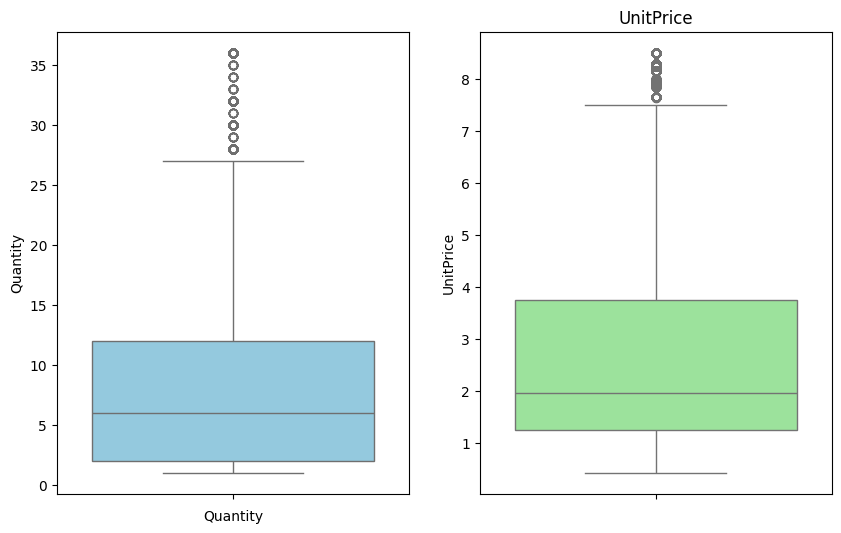

In [25]:
plt.figure(figsize = (10,6))
plt.subplot(1,2,1)
sns.boxplot(df['Quantity'],color = 'skyblue')
plt.xlabel('Quantity')

plt.subplot(1,2,2)
sns.boxplot(df['UnitPrice'],color = 'lightgreen')
plt.title('UnitPrice')

plt.show()

In [26]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,396340.000000,396340.000000,396340.000000,396340.000000
mean,560618.888861,8.889794,2.656885,15301.689070
std,13106.340114,9.530412,2.253896,1709.957487
min,536365.000000,1.000000,0.420000,12346.000000
25%,549235.000000,2.000000,1.250000,13975.000000
50%,561893.000000,6.000000,1.950000,15159.000000
75%,572092.000000,12.000000,3.750000,16803.000000
max,581587.000000,36.000000,8.500000,18287.000000


In [27]:
df['value'] = df['Quantity']*df['UnitPrice']

In [28]:
# Extracting the required features
from lifetimes.utils import summary_data_from_transaction_data

clv_df = summary_data_from_transaction_data(
    df,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    monetary_value_col='value'
) 

clv_df.head(5)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,550.570000
12348.0,3.0,283.0,358.0,107.626667
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [29]:
clv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4334 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       4334 non-null   float64
 1   recency         4334 non-null   float64
 2   T               4334 non-null   float64
 3   monetary_value  4334 non-null   float64
dtypes: float64(4)
memory usage: 169.3 KB


In [30]:
# Remove rows where T == 0 (no observed duration)
clv_df = clv_df[clv_df['T'] > 0]
clv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4333 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       4333 non-null   float64
 1   recency         4333 non-null   float64
 2   T               4333 non-null   float64
 3   monetary_value  4333 non-null   float64
dtypes: float64(4)
memory usage: 169.3 KB


In [31]:
clv_df.describe()

,frequency,recency,T,monetary_value
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,2.848835,130.637664,222.885530,218.729508
std,5.926605,132.261719,117.803077,286.690788
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,158.400000
75%,3.000000,252.000000,326.000000,326.770000
max,129.000000,373.000000,373.000000,3537.620000


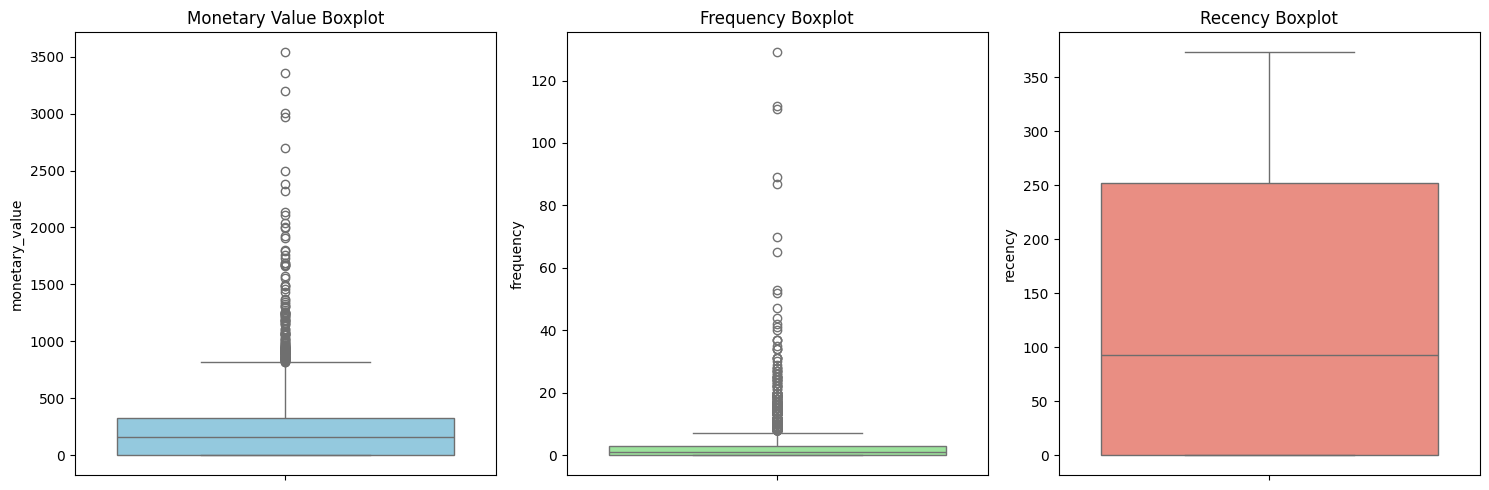

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(clv_df['monetary_value'],color = 'skyblue')
plt.title('Monetary Value Boxplot')

plt.subplot(1,3,2)
sns.boxplot(clv_df['frequency'],color = 'lightgreen')
plt.title('Frequency Boxplot')

plt.subplot(1,3,3)
sns.boxplot(clv_df['recency'],color = 'salmon')
plt.title('Recency Boxplot')

plt.tight_layout()
plt.show()

In [11]:
# M_Q1 = clv_sdf['monetary_value'].quantile(0.25)
# M_Q3 = clv_sdf['monetary_value'].quantile(0.75)
# M_IQR = M_Q3 - M_Q1

# # seperating outlier
# monetary_outliers_df = clv_sdf[(clv_sdf['monetary_value'] > (M_Q3 + M_IQR*1.25)) | 
#                                     (clv_sdf['monetary_value'] < (M_Q1 - M_IQR*1.25))].copy()
# monetary_outliers_df.describe()

In [12]:
# F_Q1 = clv_sdf['frequency'].quantile(0.25)
# F_Q3 = clv_sdf['frequency'].quantile(0.75)
# F_IQR = F_Q3 - F_Q1

# # seperating outlier
# frequency_outliers_df = clv_sdf[(clv_sdf['frequency'] > (F_Q3 + F_IQR*1.25)) | 
#                                     (clv_sdf['frequency'] < (F_Q1 - F_IQR*1.25))].copy()
# frequency_outliers_df.describe()

In [13]:
# non_outliers_df = clv_sdf[(~clv_sdf.index.isin(monetary_outliers_df.index)) &
#                                (~clv_sdf.index.isin(frequency_outliers_df.index))]
# non_outliers_df.describe()

In [14]:
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# sns.boxplot(non_outliers_df['monetary_value'],color = 'skyblue')
# plt.title('Monetary Value Boxplot')

# plt.subplot(1,3,2)
# sns.boxplot(non_outliers_df['frequency'],color = 'lightgreen')
# plt.title('Frequency Boxplot')

# plt.subplot(1,3,3)
# sns.boxplot(non_outliers_df['recency'],color = 'salmon')
# plt.title('Recency Boxplot')

# plt.tight_layout()
# plt.show()

In [15]:
# removing the customers with single purchase
# clv_sdf = 
# clv_sdf = clv_sdf[clv_sdf['frequency'] != 0]
# clv_sdf.head(5)

In [ ]:
# Cap frequency at 99th percentile
# cap = clv_df['frequency'].quantile(0.99)
# clv_df['frequency_capped'] = clv_df['frequency'].clip(upper=cap)
# clv_df

,frequency,recency,T,monetary_value,frequency_capped
CustomerID,,,,,
12346.0,0.0,0.0,325.0,0.000000,0.0
12347.0,6.0,365.0,367.0,599.701667,6.0
12348.0,3.0,283.0,358.0,261.480000,3.0
12349.0,0.0,0.0,18.0,0.000000,0.0
12350.0,0.0,0.0,310.0,0.000000,0.0
...,...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000,0.0
18281.0,0.0,0.0,180.0,0.000000,0.0
18282.0,1.0,119.0,126.0,77.840000,1.0


In [ ]:
# # Remove only the top 1% of high-frequency and high-monetary customers
# f_thresh = clv_sdf['frequency'].quantile(0.99)
# m_thresh = clv_sdf['monetary_value'].quantile(0.99)

# filtered = clv_sdf[
#     (clv_sdf['frequency'] <= f_thresh) &
#     (clv_sdf['monetary_value'] <= m_thresh) &
#     (clv_sdf['T'] > 0)
# ]


In [33]:
from lifetimes import BetaGeoFitter, GammaGammaFitter

In [35]:
model = BetaGeoFitter()
model.fit(
    frequency=clv_df['frequency'],
    recency= clv_df['recency'],
    T=clv_df['T']
)
print(model.summary)

            coef   se(coef)  lower 95% bound  upper 95% bound
r       0.822930   0.026733         0.770534         0.875327
alpha  69.090763   2.623655        63.948399        74.233127
a       0.003097   0.010432        -0.017349         0.023543
b       7.249028  25.889738       -43.494859        57.992914


In [36]:
from lifetimes import plotting

<Axes: title={'center': 'mean: 0.012, var: 0.000'}, xlabel='Transaction Rate', ylabel='Density'>

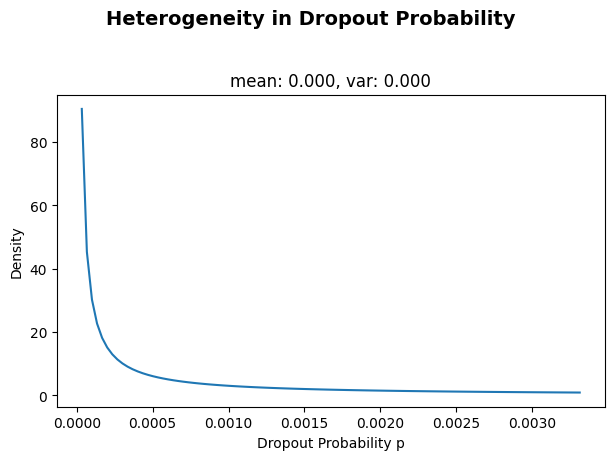

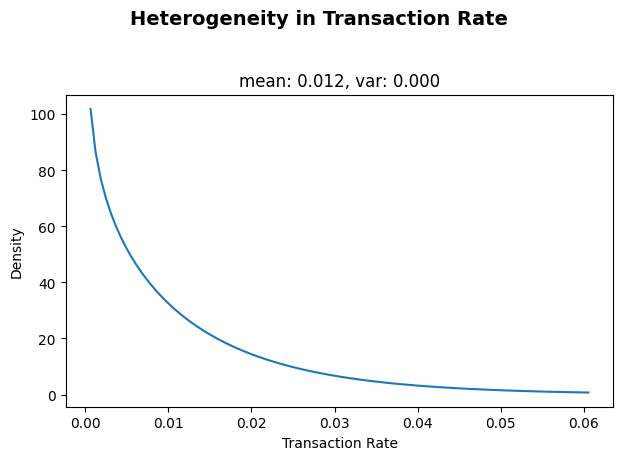

In [37]:

plotting.plot_dropout_rate_heterogeneity(model)
plotting.plot_transaction_rate_heterogeneity(model)

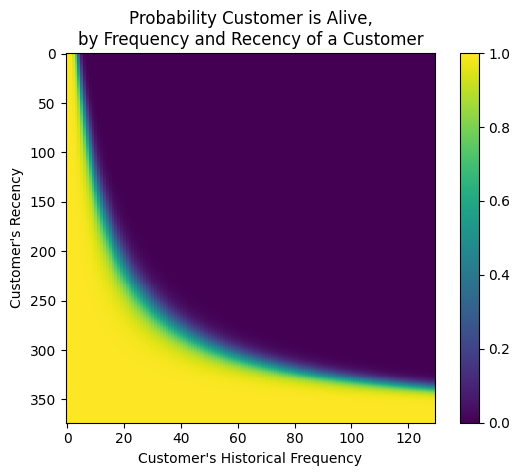

In [38]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(model);
